In [1]:

import capytaine as cpt
import numpy as np
import matplotlib.pyplot as plt
from capytaine.bem.airy_waves import airy_waves_potential, airy_waves_velocity, froude_krylov_force
from capytaine.bem.solver import BEMSolver
from capytaine.green_functions.delhommeau import Delhommeau
from capytaine.bem.engines import BasicMatrixEngine
from capytaine.bem.problems_and_results import RadiationProblem

cpt.__version__ #requires version 2.0

omega = 0.5
rho = 1025
a0 = 1
wave_num =  (omega**2)/9.81

In [2]:
def generate_body(xyz):
    mesh1 = cpt.meshes.predefined.mesh_vertical_cylinder(radius=10, length=10, center=(xyz[0], xyz[1], xyz[2]))
    body = cpt.FloatingBody(mesh1,
                           cpt.rigid_body_dofs(rotation_center = mesh1.center_of_buoyancy),
                            center_of_mass = mesh1.center_of_buoyancy)
    body.add_translation_dof(name='Heave')
    body = body.immersed_part()
    body.keep_only_dofs(['Heave'])
    body.name = f'{xyz[0]}_{xyz[1]}_{xyz[2]}'
    return body

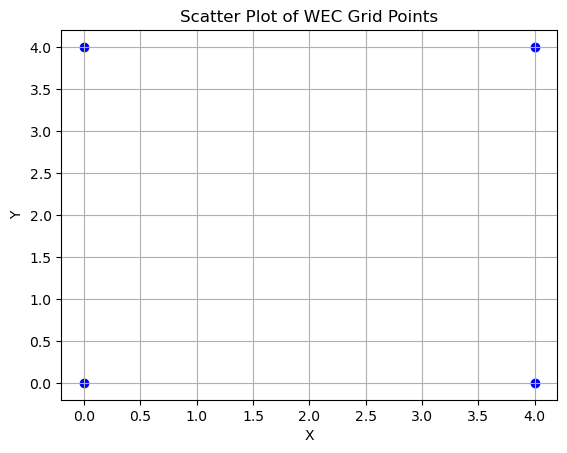

In [3]:
num_bodies = 2 #on each x, and y axis
radius = 10 #update on generate_body as well
distance = 4
grid_range = num_bodies * distance
x_coords,y_coords = np.arange(0,grid_range,distance),np.arange(0,grid_range,distance)
X, Y = np.meshgrid(x_coords, y_coords)
# Flatten the mesh grid coordinates
x_flattened = X.flatten()
y_flattened = Y.flatten()

# Plot the scatter plot
plt.scatter(x_flattened, y_flattened, color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of WEC Grid Points')
plt.grid(True)
plt.show()

In [4]:

xyzees = {(0,0,0),(100,0,0)}
#xyzees = {(x,y,0) for x,y in zip(x_flattened,y_flattened)}

bodies = [generate_body(xyz) for xyz in xyzees ]
body_to_loc = {body:xyz for xyz,body in zip(xyzees,bodies)}
cache_engine = BasicMatrixEngine(matrix_cache_size=1)
solver = cpt.BEMSolver(engine=cache_engine)


In [5]:


def calculate_theta(I,J,wave_direction = 0): 
    x1,y1= I[0],I[1]
    x2,y2 = J[0], J[1]
    theta = np.arctan2((y2-y1),(x2-x1))
    return theta


def get_neighbors(xyzees):
    neighbor = {xyz:[] for xyz in xyzees}
    for xyz in xyzees:
        for zyx in xyzees:
            if not xyz == zyx:
                neighbor[xyz].append(zyx)
    return neighbor


def get_unit_radiation_data(body,solver):
    '''This function gives A(w) and B(w) for given body'''
    #print("Getting the unit radiation data ")
    radiationProblem = cpt.RadiationProblem(body = body, water_depth = np.infty,
                                      omega=omega) 
    rsolved = solver.solve(radiationProblem)

    dataset = cpt.assemble_dataset([rsolved])

    inertia_matrix = body.compute_rigid_body_inertia().sel(
    influenced_dof='Heave', radiating_dof='Heave'
    ).values
    stiffness = body.compute_hydrostatic_stiffness().sel( 
        influenced_dof='Heave', radiating_dof='Heave').values
    added_mass =  dataset['added_mass'].sel(radiating_dof='Heave', influenced_dof='Heave').values.flatten()[0]
    rad_data = {'A':added_mass,'B':dataset['radiation_damping'].values.flatten()[0],
                'sigma_r':rsolved.sources,'potential':rsolved.potential,
                'I':inertia_matrix, 'stiffness':stiffness,
                'omega':omega}
    

    return rad_data

def get_unit_diffraction_data(solver,bodyj,bodyi):
    '''This function gives diffraction for given bodyi when interacting with bodyj
      with theta_ij  '''
   # print(f"calculating Diffraction for {bodyi}" and {bodyj})
    theta_ij = calculate_theta(body_to_loc[bodyj], body_to_loc[bodyi]) #theta kj or ji?
   # print(f"for {body_to_loc[bodyj]} and {body_to_loc[bodyi]} is theta = {theta_ij}")
    #whats this when same body..solve regular diffraction
    #F_e_i, S_i
  
    if theta_ij !=0:
      #  print("theta for different ij body diffraction problem")
        diffProblem = cpt.DiffractionProblem(body= bodyi, water_depth = np.infty,
                                        omega=omega, wave_direction = theta_ij ) 
    else:
      #  print("theta for same body diffraction problem")
        diffProblem = cpt.DiffractionProblem(body= bodyi, water_depth = np.infty,
                                        omega=omega, wave_direction = 0.0 ) 
   
         
    solved = solver.solve(diffProblem)
    
       
    diff_data = {'Fe':solved.forces['Heave'] + froude_krylov_force(diffProblem)['Heave'] ,'sigma_d':solved.sources,
                 'potential':solved.potential}
       
    return diff_data # for one body combo..run for all ij in main program #for body i


# step 2
# initialize a_ij as a piecewise function with  a_ij= a0 for same body and a_ij = 0 for j!=i.
def init_pseudo_amplitude(bodyi,bodyj,a0 = 1):
    bodyi_loc = body_to_loc[bodyi]
    bodyj_loc = body_to_loc[bodyj]
   
    if bodyi_loc != bodyj_loc:
        a_ij = 0
    else:
        a_ij = 1
    return a_ij

# step 3
# Motion response
def solve_motion_response(rad_unit_data,diff_unit_data_list,a_ij,bodies,bodyi):
      #get unit dataset 
     #print(f"for body {bodyi}")
     Mi = rad_unit_data['I'] 
     Ai  = rad_unit_data['A']
     w = omega
     Bi = rad_unit_data['B']
     Ki = rad_unit_data['stiffness']
     lhs = (w**2)*(-1*(Mi+ Ai)) + 1j* w *Bi + Ki # '-' or '+' ?
     #print(f"for the diff_list in solve motion is {diff_unit_data_list.keys()}")
     #print(lhs)
     rhs = np.sum([a_ij[bodyj] * diff_unit_data_list[bodyj]['Fe'] for bodyj in bodies ])
     
     X_i = rhs/lhs
     #print(f"Calculating Xi value {X_i}")
     return X_i



# Update incident waves amplitude 


def update_compute_potential(rad_unit_data_j, diff_unit_data_j,a_ij_list,X,bodyj,bodies,bodyi):
    ''' only update the amplitude from neighbors'''
    integrand_first = -1j* omega * rad_unit_data_j['sigma_r'] * X 
   # print(f"value of integrand first in {integrand_first}")
    result = []
    for bodyk in bodies:
                if bodyk not in [bodyj,bodyi]:
                   # print(f"{body_to_loc[bodyj]} and {body_to_loc[bodyk]}==>  {a_ij_list[bodyk]}")
                    res = a_ij_list[bodyk] * diff_unit_data_j[bodyk]['sigma_d']
                   # print(f"value of both bodies before summing \n {res}")
                    result.append(res)
    
   # print(result)
    integrand_second = np.sum(np.array(result),axis = 0)
    integrand = integrand_first + integrand_second
    #print(f"value of integrand second for {bodyj} is => {integrand_second}")
    # print(f"value of integrand{integrand}")
    #transpose it?
    integral = bodyj.mesh.surface_integral(integrand)
    #print(f"Integral by compute_potential {bodyj} is \n {integral}") # this is a scalar representing a potential at the centre
    return (-1/(4*np.pi))* integral

def check_convergence(a_ij,prev_aij): #check delta a_ij?
    a_ij_all  = np.array([a_ij[bodyi][bodyj] - prev_aij[bodyi][bodyj]  for bodyi in bodies for bodyj in bodies])
    return np.all(np.abs(a_ij_all)<=0.001)





### Update here to change the number and spacing of bodies

### Algorithm by Babarit 
1) Solve radiation problem for each body - radiation only involves the body itself like the definition
2) Solve the diffraction problem of the body and its effect on other bodies when the waves diffract
3) Initialize the starting amplitude for the pseudo plane waves


In [6]:

unit_diffraction_data_list = {bodyi:{bodyj:get_unit_diffraction_data(solver,bodyj,bodyi)
                               for bodyj in bodies} for bodyi in bodies}
unit_rad_data_list = {body:get_unit_radiation_data(body,solver) for body in bodies}


a_ij_list = {bodyi:{bodyj:init_pseudo_amplitude(bodyi,bodyj) for bodyj in bodies}  for bodyi in bodies}

#print(a_ij_list)
converged = False


count = 0
while (not converged):
  X_i_list = {body:solve_motion_response(unit_rad_data_list[body],
                                                  unit_diffraction_data_list[body],a_ij_list[body],
                                                  bodies,body) 
                                                    for body in bodies}

  new_phi_ij = {bodyi:{bodyj: update_compute_potential(unit_rad_data_list[bodyj],
                                                    unit_diffraction_data_list[bodyj],
                                                    a_ij_list[bodyj],
                                                    X_i_list[bodyj],
                                                    bodyj,bodies,bodyi) if bodyi!=bodyj else 0 for bodyj in bodies} 
                                                    for bodyi in bodies }
  #including x-xj
 #print ("Phi_ij list")
  #print(new_phi_ij)
  e_stuff = {bodyi: {bodyj:(np.exp(1j*wave_num*((body_to_loc[bodyi][0])*np.cos(calculate_theta(body_to_loc[bodyj],body_to_loc[bodyi])) + 
                                                      (body_to_loc[bodyi][1])*np.sin(calculate_theta(body_to_loc[bodyj],body_to_loc[bodyi]))
                                                        ))) for bodyj in bodies} 
                                                        for bodyi in bodies}

#- body_to_loc[bodyj][0]
  prev_aij_list = a_ij_list
  a_ij_list = {bodyi: {bodyj:new_phi_ij[bodyi][bodyj]*omega/(e_stuff[bodyi][bodyj]*9.8)  if bodyi!=bodyj else 1 for bodyj in bodies} 
                                                        for bodyi in bodies }
  # check a_ij < 10^(-3)
  print(f"updates a_i_list {a_ij_list}")

  count += 1
  converged = check_convergence(a_ij_list,prev_aij_list)
  
  print(f"step======================== \n \n {count}")
 
 
print(f"the loop has succesfully converged? {converged}")


updates a_i_list {FloatingBody(mesh=cylinder_0, dofs={Heave}, name=100_0_0): {FloatingBody(mesh=cylinder_0, dofs={Heave}, name=100_0_0): 1, FloatingBody(mesh=cylinder_6, dofs={Heave}, name=0_0_0): (0.19558277509543953+0.08816115068660699j)}, FloatingBody(mesh=cylinder_6, dofs={Heave}, name=0_0_0): {FloatingBody(mesh=cylinder_0, dofs={Heave}, name=100_0_0): (0.15507915025116814-0.14824124784214238j), FloatingBody(mesh=cylinder_6, dofs={Heave}, name=0_0_0): 1}}
step======================== 
 
 1
updates a_i_list {FloatingBody(mesh=cylinder_0, dofs={Heave}, name=100_0_0): {FloatingBody(mesh=cylinder_0, dofs={Heave}, name=100_0_0): 1, FloatingBody(mesh=cylinder_6, dofs={Heave}, name=0_0_0): (0.23898270464998742+0.07283967238367416j)}, FloatingBody(mesh=cylinder_6, dofs={Heave}, name=0_0_0): {FloatingBody(mesh=cylinder_0, dofs={Heave}, name=100_0_0): (0.19847907980571597-0.16356272614507517j), FloatingBody(mesh=cylinder_6, dofs={Heave}, name=0_0_0): 1}}
step======================== 
 
 2
up

So now do we sum all the phi_ij from other body to a body and itself without interaction and use that to solve for the added mass and such?

In [7]:
def get_total_each_body(result_dict, bodies):
    res_each_bodies = {body:[] for body in bodies}
    for bodyi,neighbor in result_dict.items():
        for bodyj,res in neighbor.items():
            if bodyi!=bodyj:
                res_each_bodies[bodyi].append(res)
    return res_each_bodies

phi_each_bodies = get_total_each_body(new_phi_ij,bodies)


phi_each_bodies 

{FloatingBody(mesh=cylinder_0, dofs={Heave}, name=100_0_0): [(-4.869046935249037+1.5752696939260096j)],
 FloatingBody(mesh=cylinder_6, dofs={Heave}, name=0_0_0): [(4.011053450999656-3.4133986242994885j)]}

In [8]:
diff_problems = {body:cpt.DiffractionProblem(body=body, water_depth = np.infty,
                                      omega=omega, wave_direction=0.) for body in bodies}

rad_problems = {body: cpt.RadiationProblem(body=body, water_depth = np.infty,
                                      omega=omega) for body in bodies}

diff_results = {body:solver.solve(problem) for body,problem in diff_problems.items()}
rad_results = {body:solver.solve(problem) for body,problem in rad_problems.items()}



In [9]:
body_total_phi = {body:np.sum(np.array(phi_each_bodies[body])) for body in phi_each_bodies.keys()}
# + diff_results[body].potential

body_total_phi

{FloatingBody(mesh=cylinder_0, dofs={Heave}, name=100_0_0): (-4.869046935249037+1.5752696939260096j),
 FloatingBody(mesh=cylinder_6, dofs={Heave}, name=0_0_0): (4.011053450999656-3.4133986242994885j)}

In [10]:
#usual_potential = {body:diff_results[body].potential for body in bodies}

def solve(body,PhiPwa,phiD,phiR,phiI):
    total_phi = PhiPwa + phiD + phiR + phiI
    pressure = 1j * omega * rho * total_phi
    force = body.integrate_pressure(pressure)
    return force

phi_Indv = {body:airy_waves_potential(np.array(body_to_loc[body]),diff_problems[body]) for body in bodies}

body_force = {body:solve(body,body_total_phi[body], 
                         unit_diffraction_data_list[body][body]['potential'],
                         unit_rad_data_list[body]['potential'], phi_Indv[body]
                         ) for body in  bodies}
# + diff_results[body].potential

body_force


{FloatingBody(mesh=cylinder_0, dofs={Heave}, name=100_0_0): {'Heave': (-1701518.8185502454+852772.2381792255j)},
 FloatingBody(mesh=cylinder_6, dofs={Heave}, name=0_0_0): {'Heave': (3364808.885218418+573176.7397448362j)}}

#### Solving single separately to compare the results


### Solving combined (by joining) to compare the results 

In [11]:
# Combine the two individual bodies into a single body.
all_bodies =  bodies[0].join_bodies(*bodies[1:])
all_bodies.keep_immersed_part()

# The merged body can be used to define the problems in the usual way
problems = [cpt.RadiationProblem(body=all_bodies, radiating_dof=dof, omega=1.0) for dof in all_bodies.dofs]
problems = [cpt.DiffractionProblem(body=all_bodies, wave_direction=0.0, omega=omega)]

# Solves the problem
solver = cpt.BEMSolver()
results_all_bodies = [solver.solve(problem) for problem in problems]


### Excitation force for all bodies when Joined

In [12]:
theoretical_joint = results_all_bodies[0].forces['0_0_0__Heave'] + froude_krylov_force(problems[0])['0_0_0__Heave']
theoretical_joint

(1940936.4072283448-80733.40076351748j)

##### excitation force for a individual body

In [13]:
#print(bodies) - second one is the 0_0_0
single_body = diff_results[bodies[1]].forces ['Heave']  + froude_krylov_force(diff_problems[bodies[1]])['Heave']
single_body

(2003976.973441435-116853.7610143722j)

### PWA approximation  gets very close to the theoretical one..

the difference between two approximation

In [14]:
np.abs(body_force[bodies[0]]['Heave'])/np.abs(theoretical_joint) * 100 #np.abs takes the magnitude of complex excitation force

97.973975523436

% of the interaction is captured by PWA at that distance?